Tải file excel lên driver và lấy đường dẫn để cho vào file_path

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


tiền xử lý dữ liệu

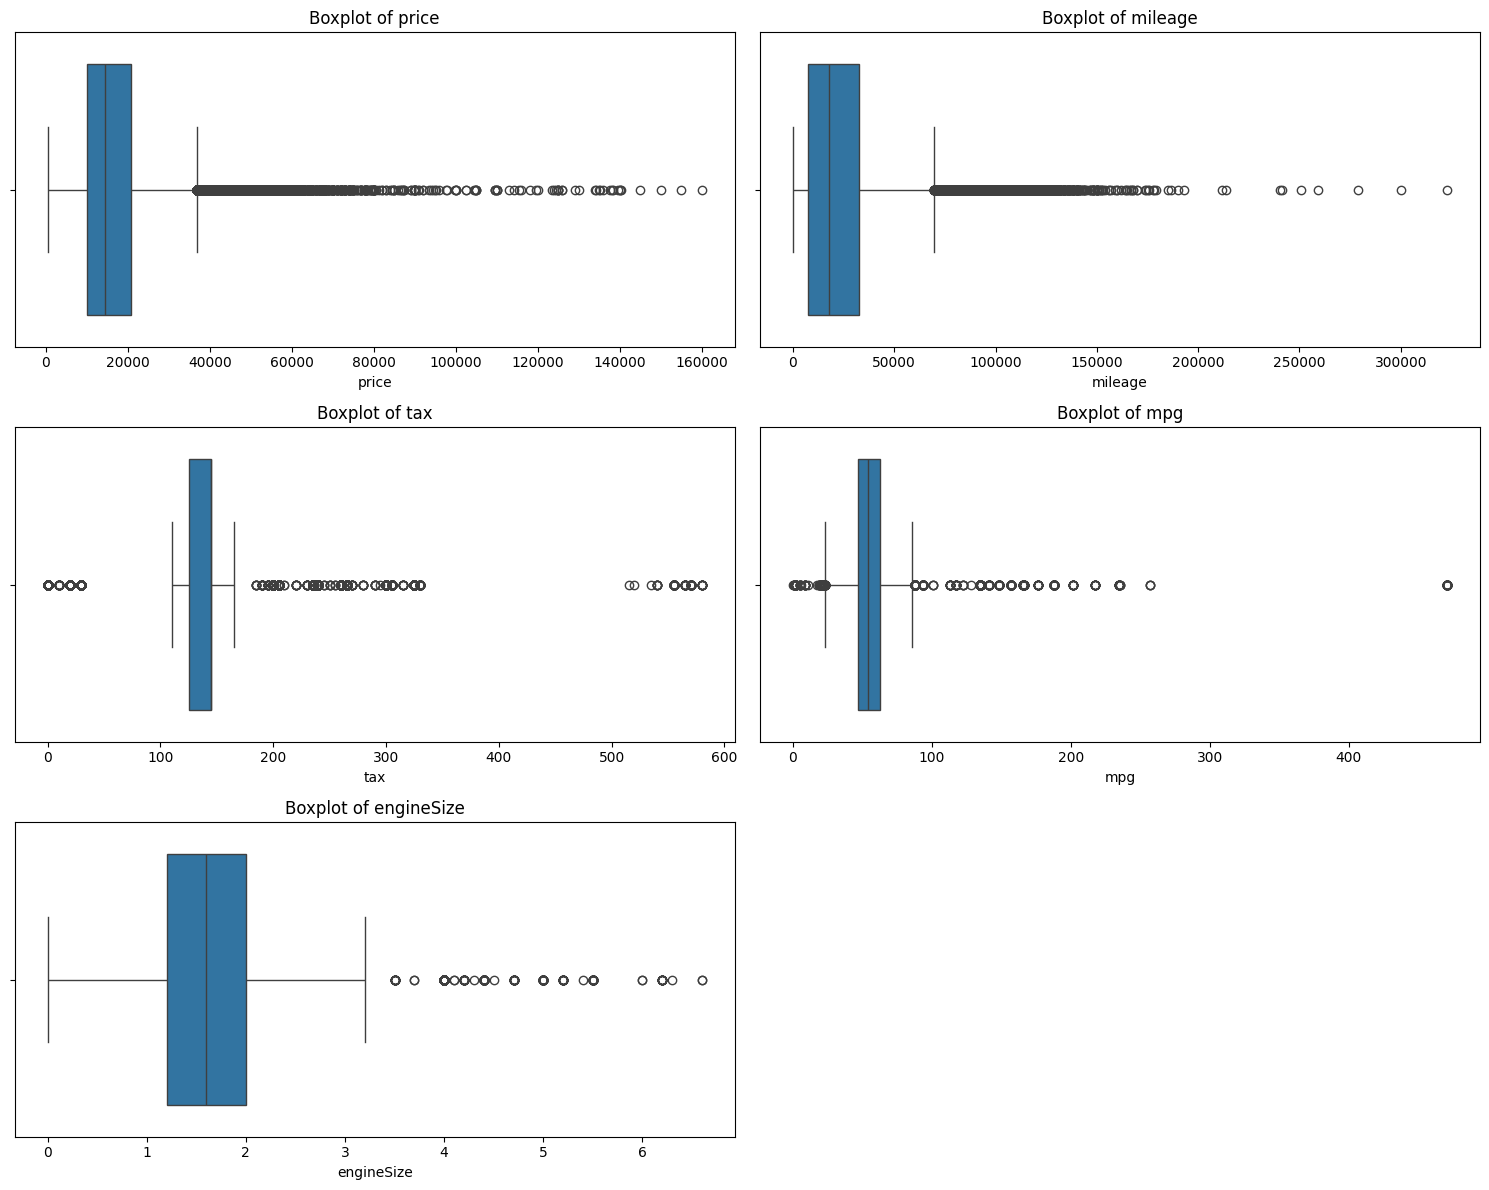

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load lại dữ liệu từ file (nếu chưa có biến df)
file_path = "/content/drive/MyDrive/CarsData.csv"
df = pd.read_csv(file_path)

# Chọn các cột số để kiểm tra outliers
numeric_cols = ['price', 'mileage', 'tax', 'mpg', 'engineSize']

# Vẽ boxplot để trực quan hóa outliers
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Ẩn subplot thừa nếu có
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# Re-import after code state reset
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Load lại file
file_path = "/content/drive/MyDrive/CarsData.csv"
df = pd.read_csv(file_path)

# Loại bỏ cột model nếu có
if 'model' in df.columns:
    df = df.drop(columns=['model'])

# Tính các ngưỡng 99th percentile
price_threshold = df['price'].quantile(0.99)
mileage_threshold = df['mileage'].quantile(0.99)

# Áp dụng điều kiện loại bỏ outliers
df_cleaned = df[
    (df['price'] <= price_threshold) &
    (df['mileage'] <= mileage_threshold) &
    (df['mpg'] >= 10) & (df['mpg'] <= 100) &
    (df['engineSize'] > 0) & (df['engineSize'] <= 5) &
    (df['tax'] <= 500)
]

# So sánh số lượng trước và sau khi loại outliers
original_rows = df.shape[0]
cleaned_rows = df_cleaned.shape[0]
removed_rows = original_rows - cleaned_rows

original_rows, cleaned_rows, removed_rows

# Xác định các cột
categorical_cols = ['transmission', 'Manufacturer', 'fuelType']
numerical_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
target_col = 'price'

# Xác định biến đầu vào và đầu ra
X = df.drop(columns=[target_col])
y = df[target_col]

# Pipeline tiền xử lý
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Áp dụng pipeline
X_processed = preprocessor.fit_transform(X)

# Trả về thống kê cuối cùng sau xử lý
df_processed = pd.DataFrame(X_processed)
df_stats = df_processed.describe()

df_stats
# Lấy tên cột sau khi One-Hot Encoding
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)

# Tạo DataFrame từ dữ liệu đã xử lý
feature_names = numerical_cols + list(cat_feature_names)
df_processed = pd.DataFrame(X_processed, columns=feature_names)

# 1. Hiển thị 5 dòng đầu dữ liệu đã xử lý
print("\n🔍 Dữ liệu sau xử lý (5 dòng đầu):")
print(df_processed.head())

# 2. Thống kê mô tả (describe)
print("\n📊 Thống kê dữ liệu đã xử lý:")
print(df_processed.describe())

# 3. Số lượng dòng sau khi xử lý outlier
print(f"\n✅ Số lượng dòng còn lại sau xử lý outliers: {len(df)}")

# Lưu dữ liệu đã xử lý vào file mới
processed_file_path = "CarsData_Processed.csv"
df_processed.to_csv(processed_file_path, index=False)

print(f"\n💾 Dữ liệu đã xử lý đã được lưu vào file: {processed_file_path}")


🔍 Dữ liệu sau xử lý (5 dòng đầu):
       year   mileage       tax       mpg  engineSize  transmission_Manual  \
0 -0.031389 -0.550287  0.392342  0.302466   -1.190382                  1.0   
1 -0.031389 -0.665668  0.392342  0.228308   -1.190382                  1.0   
2  0.912609 -1.025863  0.392342 -0.346420    0.599900                  0.0   
3 -0.031389  0.367533  0.471260  0.469322    0.599900                  1.0   
4 -0.031389 -0.183587  0.076670 -0.055966   -0.832326                  1.0   

   transmission_Other  transmission_Semi-Auto  Manufacturer_BMW  \
0                 0.0                     0.0               0.0   
1                 0.0                     0.0               0.0   
2                 0.0                     1.0               1.0   
3                 0.0                     0.0               0.0   
4                 0.0                     0.0               0.0   

   Manufacturer_ford  Manufacturer_hyundi  Manufacturer_merc  \
0                0.0         

Huấn luyện mô hình chưa có siêu tham số


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
import lightgbm as lgb

# Load dữ liệu
df = pd.read_csv("/content/drive/MyDrive/CarsData.csv")  # đổi tên nếu khác

# Tách features và target
X = df.drop("price", axis=1)
y = df["price"]

# Xác định các cột phân loại và số
categorical_features = ['transmission', 'fuelType', 'Manufacturer']
numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']

# Pipeline tiền xử lý
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Tách train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Các mô hình cần huấn luyện
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=10),
    "Lasso Regression": Lasso(alpha=0.005, max_iter=10000),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": lgb.LGBMRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(random_state=42, max_iter=1000)
}

# Hàm đánh giá mô hình
def evaluate_model(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred)
    }

# Huấn luyện, dự đoán và đánh giá
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results[name] = evaluate_model(y_test, y_pred)

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("RMSE")
print(results_df)

# Trực quan hóa
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['MAE', 'RMSE', 'R²', 'MAPE']
titles = ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'R² Score', 'Mean Absolute Percentage Error (MAPE)']

for ax, metric, title in zip(axs.flatten(), metrics, titles):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()


Biểu đồ trực quan hóa cho các mô hình chưa có tham số

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.838e+08, tolerance: 7.613e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 78169, number of used features: 21
[LightGBM] [Info] Start training from score 16785.344126


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


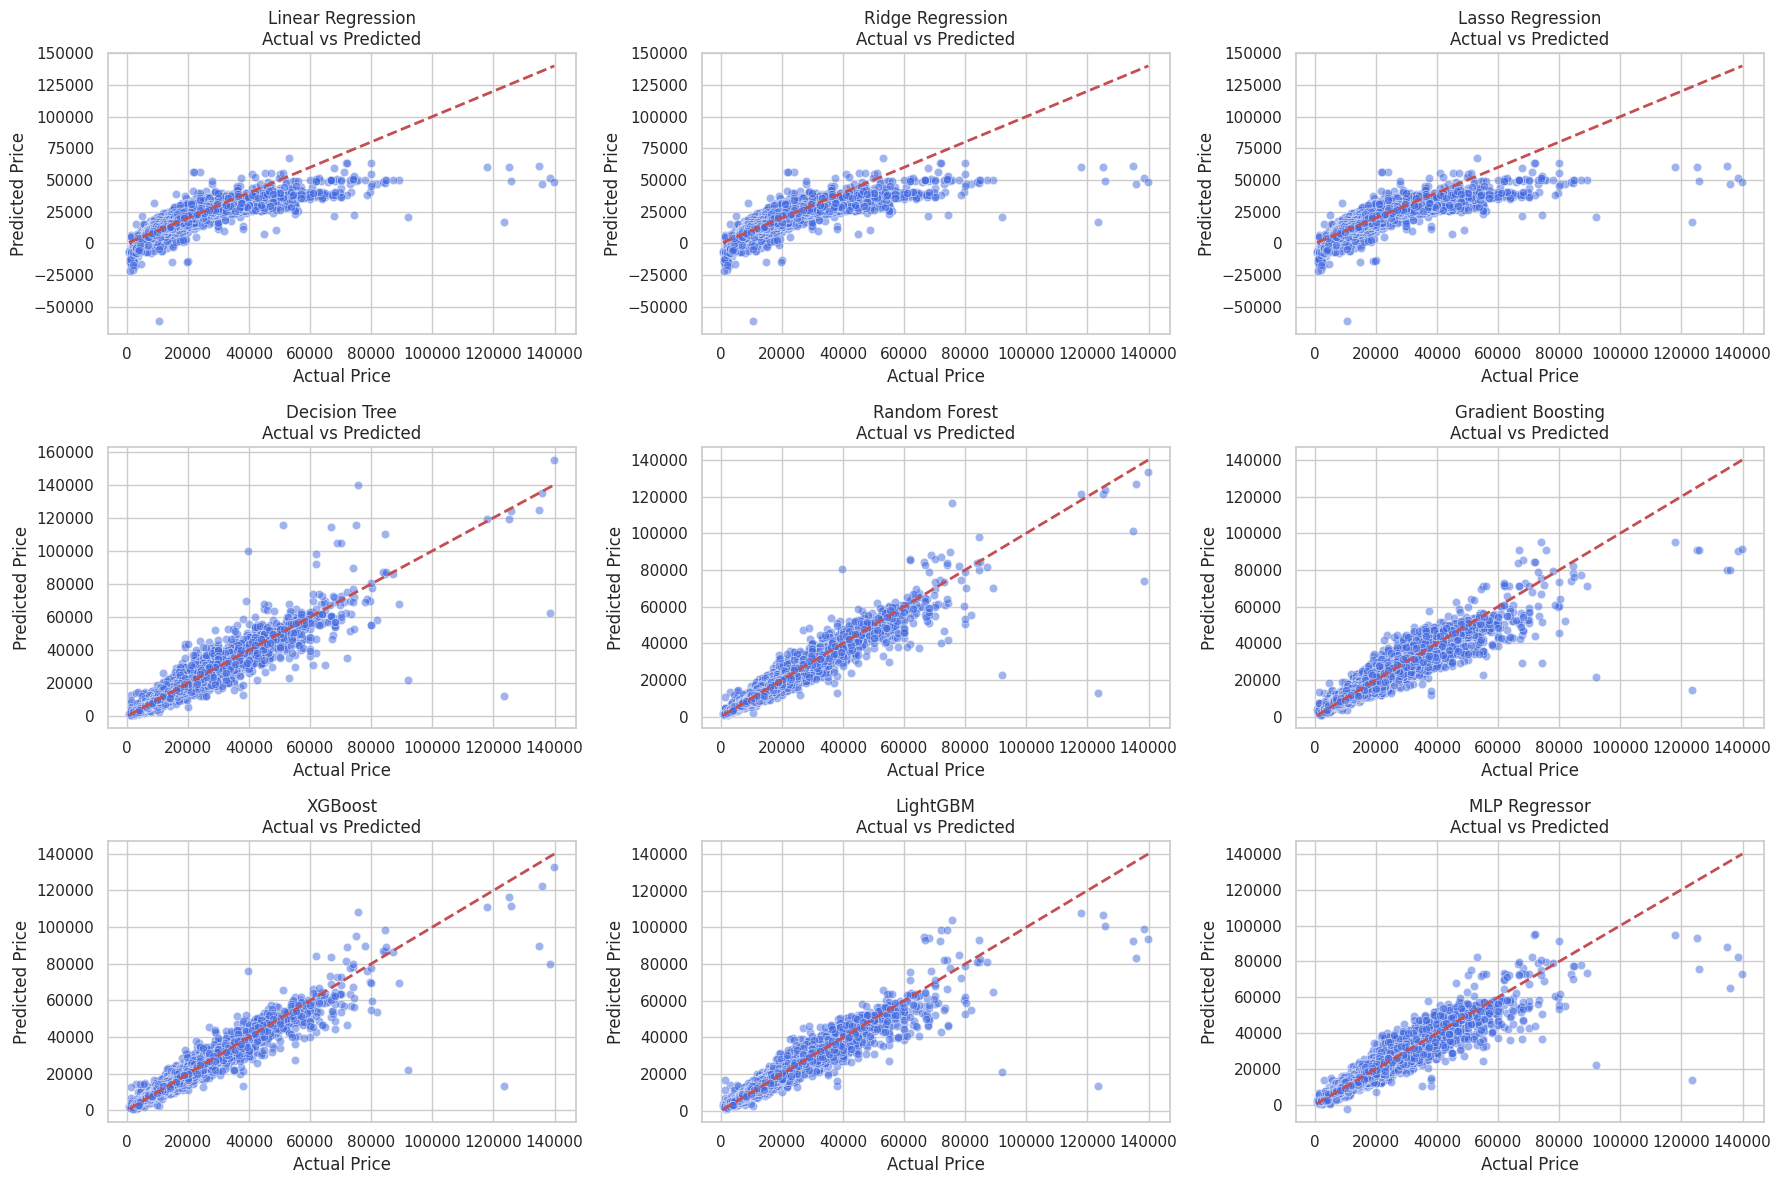

In [ ]:
# Vẽ biểu đồ scatter cho từng mô hình: Actual vs Predicted
import matplotlib.pyplot as plt
import seaborn as sns

# Lặp qua từng mô hình và vẽ biểu đồ
n_models = len(models)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

plt.figure(figsize=(18, n_rows * 4))

for idx, (name, model) in enumerate(models.items(), 1):
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Vẽ biểu đồ
    plt.subplot(n_rows, n_cols, idx)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color="royalblue")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'{name}\nActual vs Predicted')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")

plt.tight_layout()
plt.show()


In [ ]:
Huấn luyện mô hình đã thêm giá trị của các siêu tham số

                           MAE         RMSE        R²      MAPE
XGBoost            1181.961792  1764.491570  0.955268  0.075284
Random Forest      1248.067990  1873.804051  0.949554  0.080806
Gradient Boosting  1301.062783  1897.060252  0.948294  0.083552
MLP Regressor      1426.311614  2154.267530  0.933323  0.089067
Lasso Regression   2476.127575  3360.971570  0.837704  0.185550
Ridge Regression   2476.222961  3361.030715  0.837698  0.185559
Linear Regression  2476.329165  3361.151359  0.837687  0.185572


<ipython-input-2-e8a66f43432d>:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
<ipython-input-2-e8a66f43432d>:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-2-e8a66f43432d>:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
<ipython-input-2-e8a66f43432d>:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  

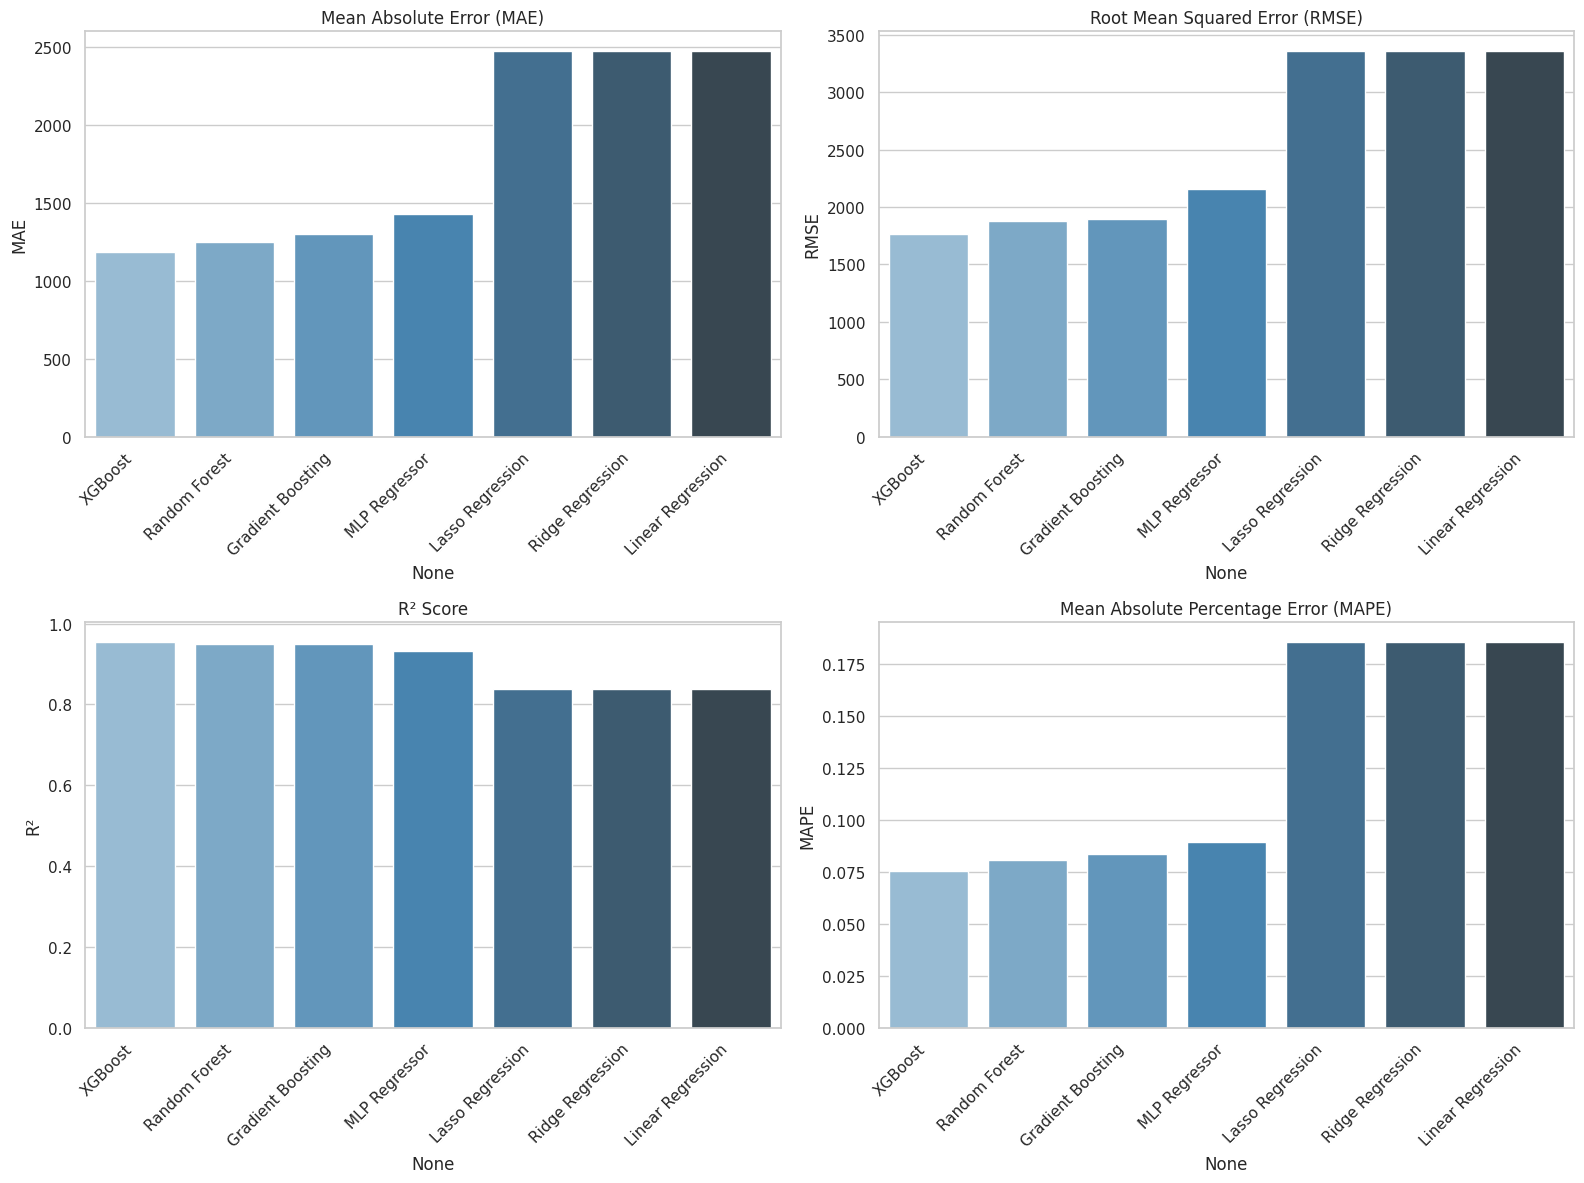

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV


# --------------------------------------------
# 1. Tiền xử lý dữ liệu và loại bỏ outliers
# --------------------------------------------
file_path = "/content/drive/MyDrive/CarsData.csv"
df = pd.read_csv(file_path)

# Loại bỏ cột 'model' nếu có
if 'model' in df.columns:
    df = df.drop(columns=['model'])

# Loại bỏ outliers theo ngưỡng 99th percentile
price_threshold = df['price'].quantile(0.99)
mileage_threshold = df['mileage'].quantile(0.99)

df_cleaned = df[
    (df['price'] <= price_threshold) &
    (df['mileage'] <= mileage_threshold) &
    (df['mpg'] >= 10) & (df['mpg'] <= 100) &
    (df['engineSize'] > 0) & (df['engineSize'] <= 5) &
    (df['tax'] <= 500)
]
# --------------------------------------------
# 2. Định nghĩa cột và pipeline
# --------------------------------------------
categorical_features = ['transmission', 'fuelType', 'Manufacturer']
numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
target_col = 'price'

X = df_cleaned.drop(columns=[target_col])
y = df_cleaned[target_col]

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

# --------------------------------------------
# 3. Chia tập train/test
# --------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# --------------------------------------------
# 4. Định nghĩa
# --------------------------------------------


param_grid_ridge = {
    "regressor__alpha": [0.01, 0.1, 1, 10, 100],
    "regressor__solver": ['auto', 'svd', 'cholesky', 'lsqr'],
    "regressor__tol": [1e-3, 1e-4, 1e-5]
}

param_grid_lasso = {
    "regressor__alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "regressor__max_iter": [1000, 5000, 10000],
    "regressor__tol": [1e-3, 1e-4, 1e-5]
}

# --------------------------------------------
# 5. Danh sách các mô hình
# --------------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.01, solver='lsqr', tol=0.0001),
    "Lasso Regression": Lasso(alpha= 0.1, max_iter= 1000, tol = 1e-05),
    "Random Forest": RandomForestRegressor(
      n_estimators=200,
      min_samples_split=5,
      min_samples_leaf=1,
      max_features='sqrt',
      max_depth=30,
      random_state=42,  # Thêm để đảm bảo tái lập kết quả
      n_jobs=-1        # Sử dụng tất cả CPU để tăng tốc
),
    "Gradient Boosting": GradientBoostingRegressor(
      subsample=0.7,
      n_estimators=200,
      min_samples_split=5,
      min_samples_leaf=2,
      max_depth=7,
      learning_rate=0.1,
      random_state=42,
      validation_fraction=0.1  # Thêm để early stopping nếu cần
),
    "XGBoost": xgb.XGBRegressor(
    subsample=0.9,
    reg_lambda=2,           # L2 regularization
    reg_alpha=0,            # L1 regularization
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    colsample_bytree=0.7,
    random_state=42,
    eval_metric='rmse',     # Metric đánh giá
    n_jobs=-1
),
     "MLP Regressor": MLPRegressor(
        max_iter=1000,
        learning_rate_init=0.01,
        learning_rate='adaptive',
        hidden_layer_sizes=(100, 50),
        early_stopping=True,
        alpha=0.001,
        activation='tanh',
        random_state=42)
}

# --------------------------------------------
# 5. Hàm đánh giá mô hình
# --------------------------------------------
def evaluate_model(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred)
    }

# --------------------------------------------
# 6. Huấn luyện và đánh giá các mô hình
# --------------------------------------------
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results[name] = evaluate_model(y_test, y_pred)

# --------------------------------------------
# 7. Trực quan hóa kết quả
# --------------------------------------------
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("RMSE")
print(results_df)

sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['MAE', 'RMSE', 'R²', 'MAPE']
titles = ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'R² Score', 'Mean Absolute Percentage Error (MAPE)']

for ax, metric, title in zip(axs.flatten(), metrics, titles):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()


In [ ]:
lưu model đã huấn luyện

In [3]:
# Chọn model tốt nhất
best_model = models["XGBoost"]

# Gói pipeline và huấn luyện trên toàn bộ dữ liệu
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_model)
])
final_pipeline.fit(X, y)

# Lưu pipeline đã huấn luyện
import joblib
joblib.dump(final_pipeline, "car_price_model.pkl")


['car_price_model.pkl']

In [ ]:
trực quan hóa các mô hình đã huấn luyện với siêu tham số

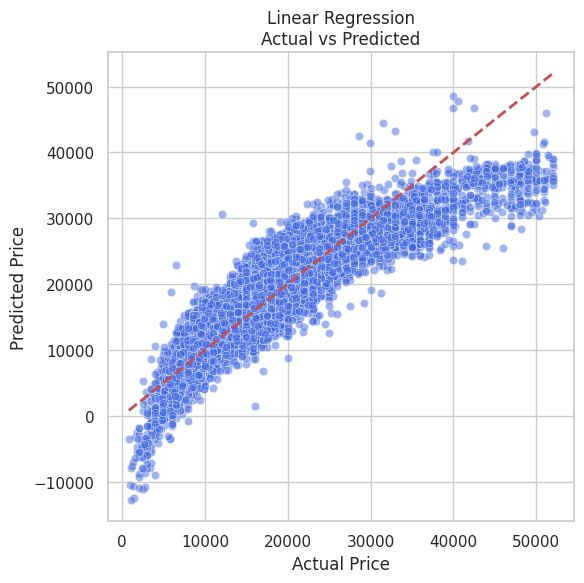

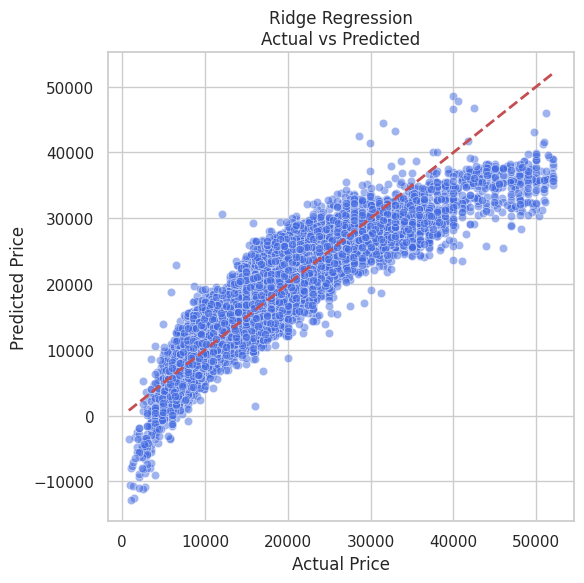

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)


    # Tạo hình riêng
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color="royalblue")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'{name}\nActual vs Predicted')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.tight_layout()
    plt.show()



In [ ]:
Tối ưu hóa siêu tham số của mô hình linear regression , lasso và ridge

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categ

                              MAE         RMSE        R²      MAPE
Lasso (GridSearchCV)  2476.127575  3360.971570  0.837704  0.185550
Ridge (alpha=10)      2475.898309  3360.976582  0.837703  0.185508
Ridge (GridSearchCV)  2476.222961  3361.030715  0.837698  0.185559
Lasso (alpha=0.005)   2476.332782  3361.141439  0.837688  0.185571
Linear Regression     2476.329165  3361.151359  0.837687  0.185572


<ipython-input-6-7119cf7d9153>:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
<ipython-input-6-7119cf7d9153>:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-6-7119cf7d9153>:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
<ipython-input-6-7119cf7d9153>:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  

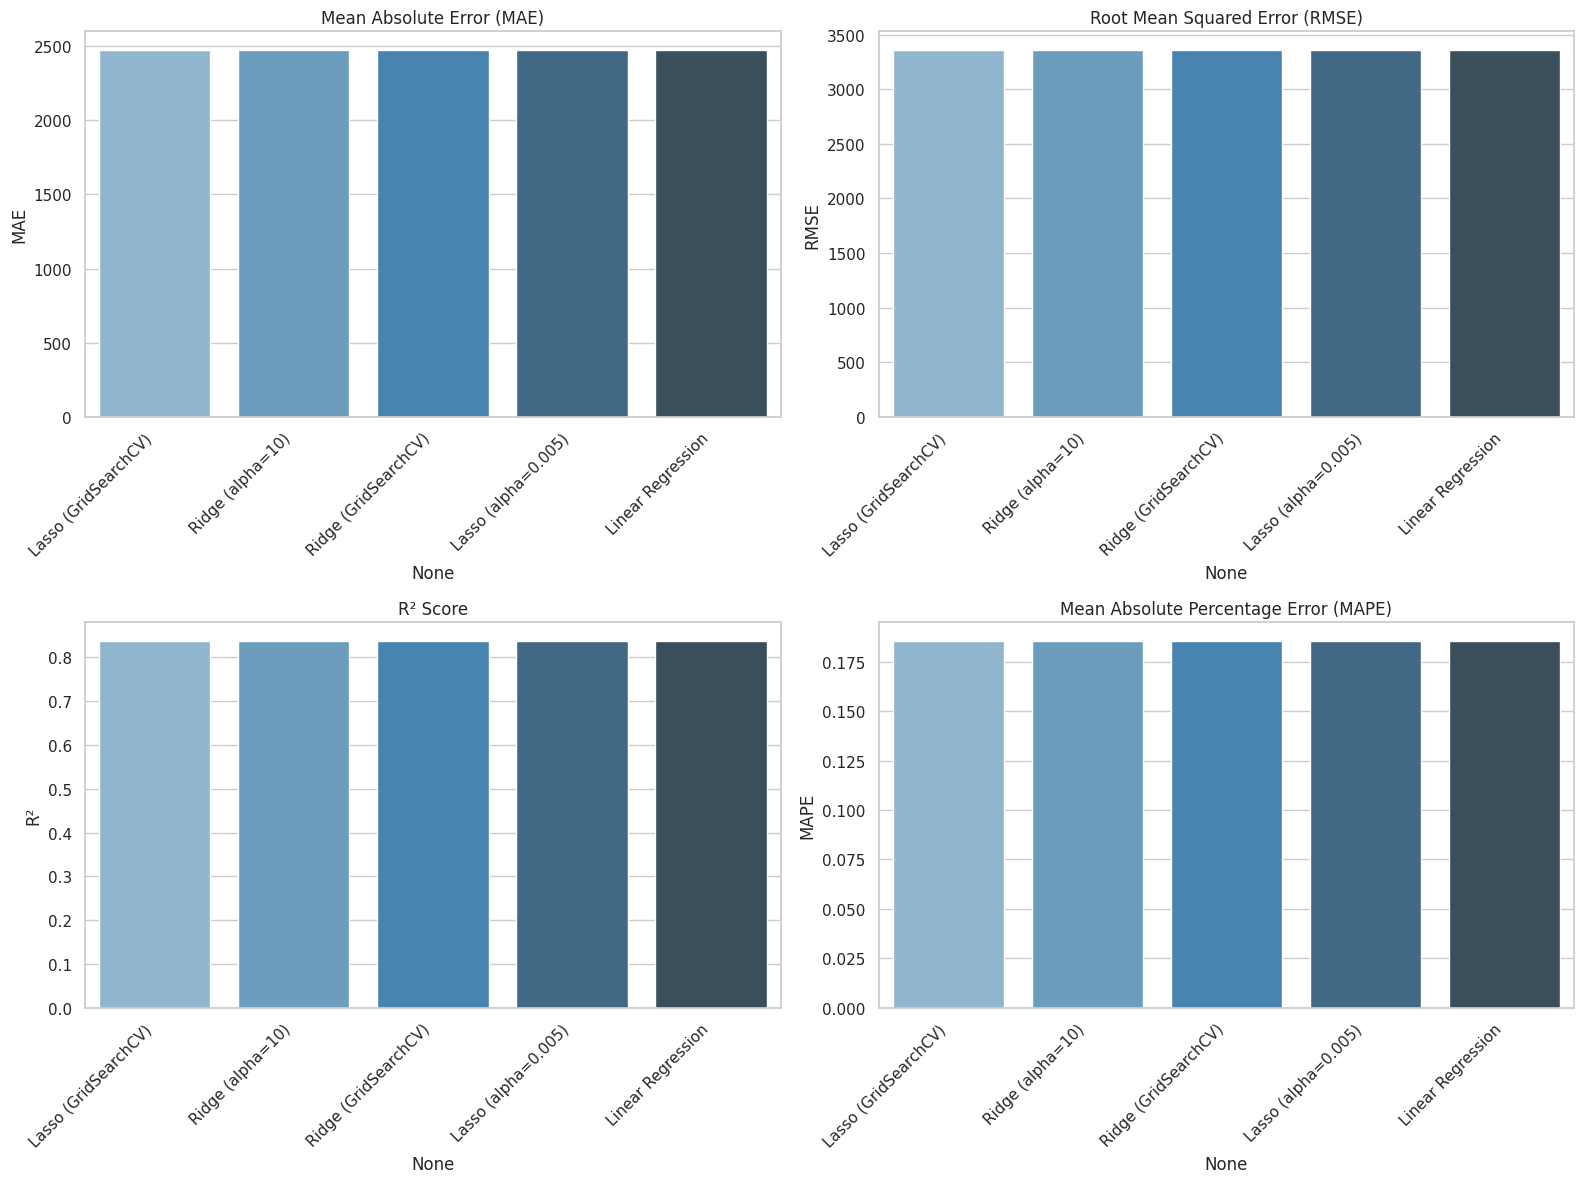


Best Ridge Parameters: {'regressor__alpha': 0.01, 'regressor__solver': 'lsqr', 'regressor__tol': 0.0001}
Best Lasso Parameters: {'regressor__alpha': 0.1, 'regressor__max_iter': 1000, 'regressor__tol': 1e-05}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 1. Load dữ liệu
file_path = "/content/drive/MyDrive/CarsData.csv"
df = pd.read_csv(file_path)

# 2. Loại bỏ cột không cần thiết & loại outliers
if 'model' in df.columns:
    df = df.drop(columns=['model'])

price_threshold = df['price'].quantile(0.99)
mileage_threshold = df['mileage'].quantile(0.99)

df_cleaned = df[
    (df['price'] <= price_threshold) &
    (df['mileage'] <= mileage_threshold) &
    (df['mpg'] >= 10) & (df['mpg'] <= 100) &
    (df['engineSize'] > 0) & (df['engineSize'] <= 5) &
    (df['tax'] <= 500)
]

# 3. Xác định features và target
categorical_features = ['transmission', 'fuelType', 'Manufacturer']
numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
target_col = 'price'

X = df_cleaned.drop(columns=[target_col])
y = df_cleaned[target_col]

# 4. Pipeline tiền xử lý
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
])

# 5. Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Các mô hình cơ bản
models = {
    "Linear Regression": LinearRegression(),
    "Ridge (alpha=10)": Ridge(alpha=10),
    "Lasso (alpha=0.005)": Lasso(alpha=0.005, max_iter=10000)
}

# 7. Hàm đánh giá
def evaluate_model(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred)
    }

# 8. Huấn luyện và đánh giá mô hình cơ bản
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results[name] = evaluate_model(y_test, y_pred)

# 9. GridSearchCV cho Ridge
param_grid_ridge = {
    "regressor__alpha": [0.01, 0.1, 1, 10, 100],
    "regressor__solver": ['auto', 'svd', 'cholesky', 'lsqr'],
    "regressor__tol": [1e-3, 1e-4, 1e-5]
}

ridge_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Ridge())
])
grid_ridge = GridSearchCV(ridge_pipe, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train, y_train)
y_pred_ridge = grid_ridge.predict(X_test)
results["Ridge (GridSearchCV)"] = evaluate_model(y_test, y_pred_ridge)

# 10. GridSearchCV cho Lasso
param_grid_lasso = {
    "regressor__alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "regressor__max_iter": [1000, 5000, 10000],
    "regressor__tol": [1e-3, 1e-4, 1e-5]
}

lasso_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Lasso())
])
grid_lasso = GridSearchCV(lasso_pipe, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_lasso.fit(X_train, y_train)
y_pred_lasso = grid_lasso.predict(X_test)
results["Lasso (GridSearchCV)"] = evaluate_model(y_test, y_pred_lasso)

# 11. Hiển thị kết quả
results_df = pd.DataFrame(results).T.sort_values("RMSE")
print(results_df)

# 12. Trực quan hóa
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['MAE', 'RMSE', 'R²', 'MAPE']
titles = ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'R² Score', 'Mean Absolute Percentage Error (MAPE)']

for ax, metric, title in zip(axs.flatten(), metrics, titles):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

# 13. In ra best params nếu cần
print("\nBest Ridge Parameters:", grid_ridge.best_params_)
print("Best Lasso Parameters:", grid_lasso.best_params_)


In [ ]:
Tối ưu hóa siêu tham số của mô hình Random Forest, Gradient Boosting và XGBoost

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

🔍 Best RF params: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 30}
🔍 Best GB params: {'regressor__subsample': 0.7, 'regressor__n_estimators': 200, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.1}
🔍 Best XGB params: {'regressor__subsample': 0.9, 'regressor__reg_lambda': 2, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 200, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.7}
                                 MAE         RMSE        R²      MAPE
XGBoost (Opt)            1181.961792  1764.491570  0.955268  0.075284
Random Forest (Opt)      1248.067990  1873.804051  0.949554  0.080806
Gradient Boosting (Opt)  1301.062783  1897.060252  0.948294  0.083552


<ipython-input-23-28b1c575ba48>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
<ipython-input-23-28b1c575ba48>:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-23-28b1c575ba48>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
<ipython-input-23-28b1c575ba48>:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  

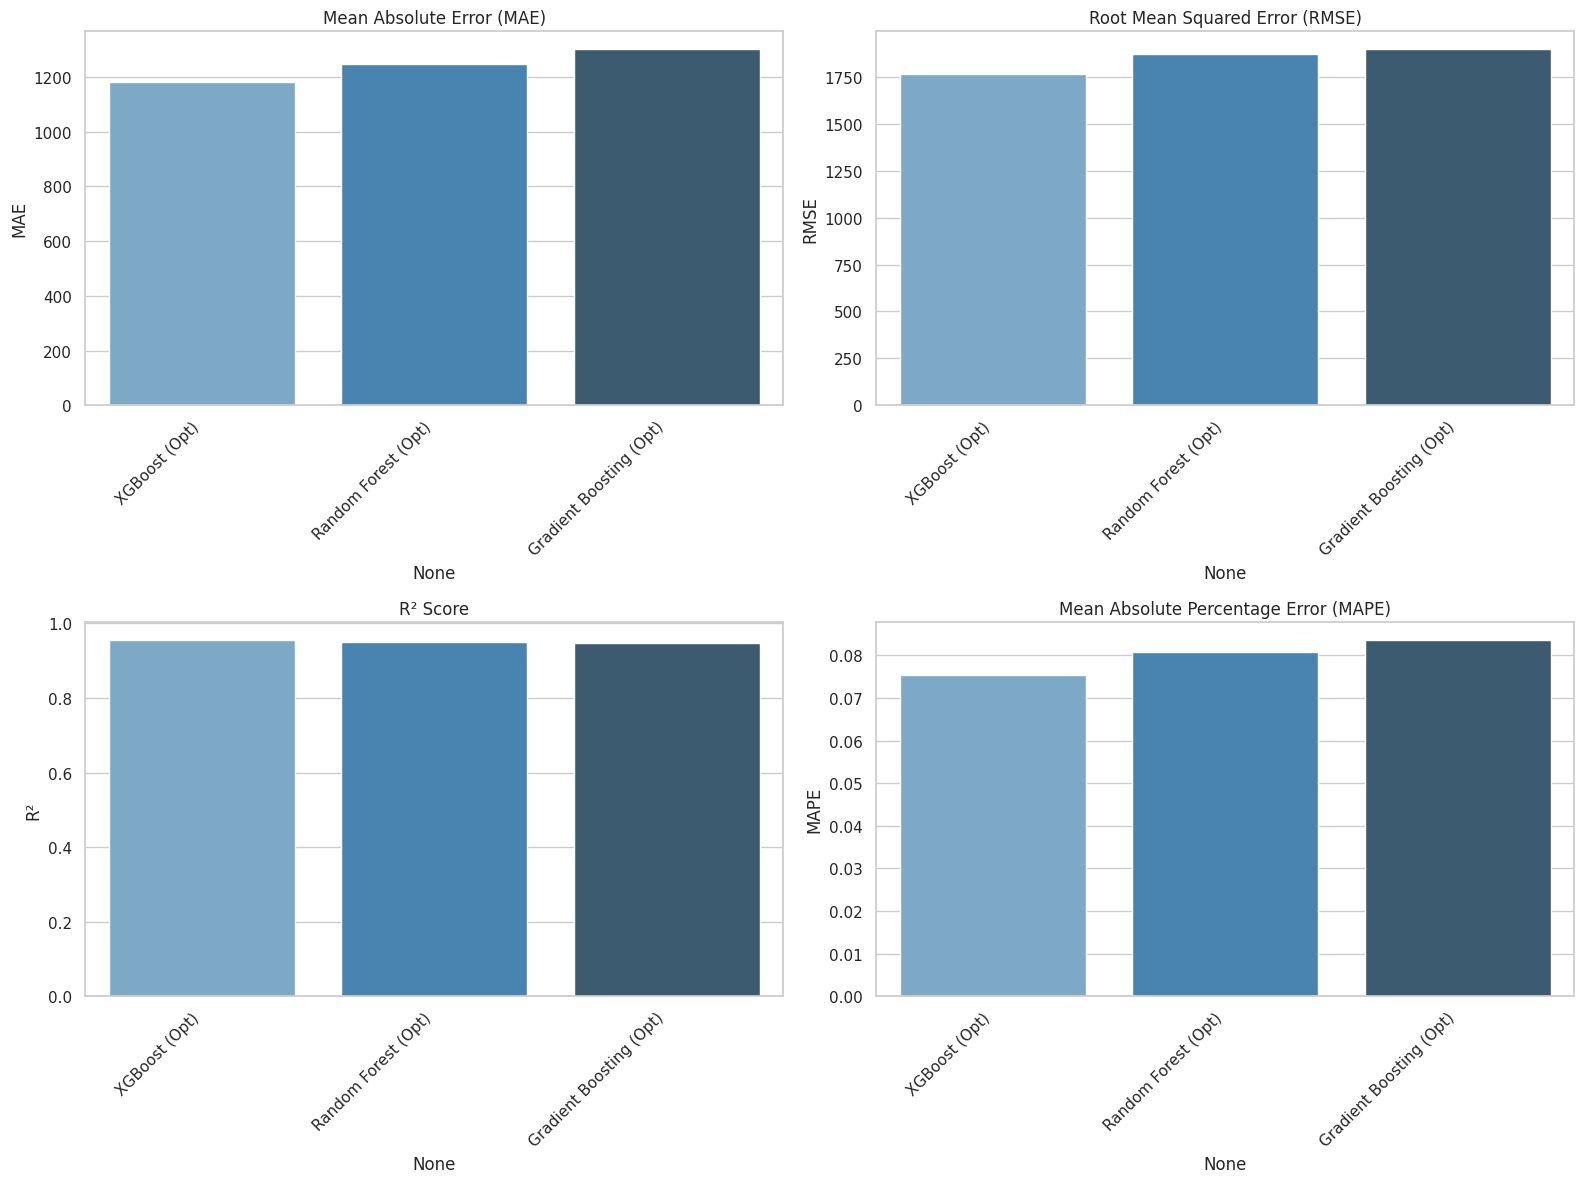

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# ------------------------------
# 1. Tạo pipeline tiền xử lý
# ------------------------------
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

pipe_gb = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(objective='reg:squarederror', random_state=42))
])

# ------------------------------
# 2. Khai báo không gian siêu tham số
# ------------------------------
rf_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt']
}

gb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.7, 0.9, 1.0],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

xgb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 6, 10],
    'regressor__subsample': [0.7, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.9, 1.0],
    'regressor__reg_alpha': [0, 0.01, 0.1],
    'regressor__reg_lambda': [0.5, 1, 2]
}

# ------------------------------
# 3. Tối ưu bằng RandomizedSearchCV
# ------------------------------
rf_search = RandomizedSearchCV(pipe_rf, rf_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
gb_search = RandomizedSearchCV(pipe_gb, gb_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
xgb_search = RandomizedSearchCV(pipe_xgb, xgb_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

# ------------------------------
# 4. Huấn luyện
# ------------------------------
rf_search.fit(X_train, y_train)
gb_search.fit(X_train, y_train)
xgb_search.fit(X_train, y_train)

# ------------------------------
# 5. Dự đoán và đánh giá
# ------------------------------
results = {}

results["Random Forest (Opt)"] = evaluate_model(y_test, rf_search.predict(X_test))
results["Gradient Boosting (Opt)"] = evaluate_model(y_test, gb_search.predict(X_test))
results["XGBoost (Opt)"] = evaluate_model(y_test, xgb_search.predict(X_test))

# ------------------------------
# 6. In kết quả và trực quan hóa
# ------------------------------
print("🔍 Best RF params:", rf_search.best_params_)
print("🔍 Best GB params:", gb_search.best_params_)
print("🔍 Best XGB params:", xgb_search.best_params_)

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("RMSE")
print(results_df)

# Trực quan hóa
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['MAE', 'RMSE', 'R²', 'MAPE']
titles = ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'R² Score', 'Mean Absolute Percentage Error (MAPE)']

for ax, metric, title in zip(axs.flatten(), metrics, titles):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()


In [ ]:
Tối ưu hóa giá tri siêu tham số của MLP

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


                               MAE         RMSE        R²      MAPE
MLP Regressor (Tuned)  1439.680321  2186.691737  0.931301  0.089775
Linear Regression      2476.329165  3361.151359  0.837687  0.185572


<ipython-input-29-e5f5a474ccb6>:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
<ipython-input-29-e5f5a474ccb6>:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-29-e5f5a474ccb6>:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
<ipython-input-29-e5f5a474ccb6>:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator

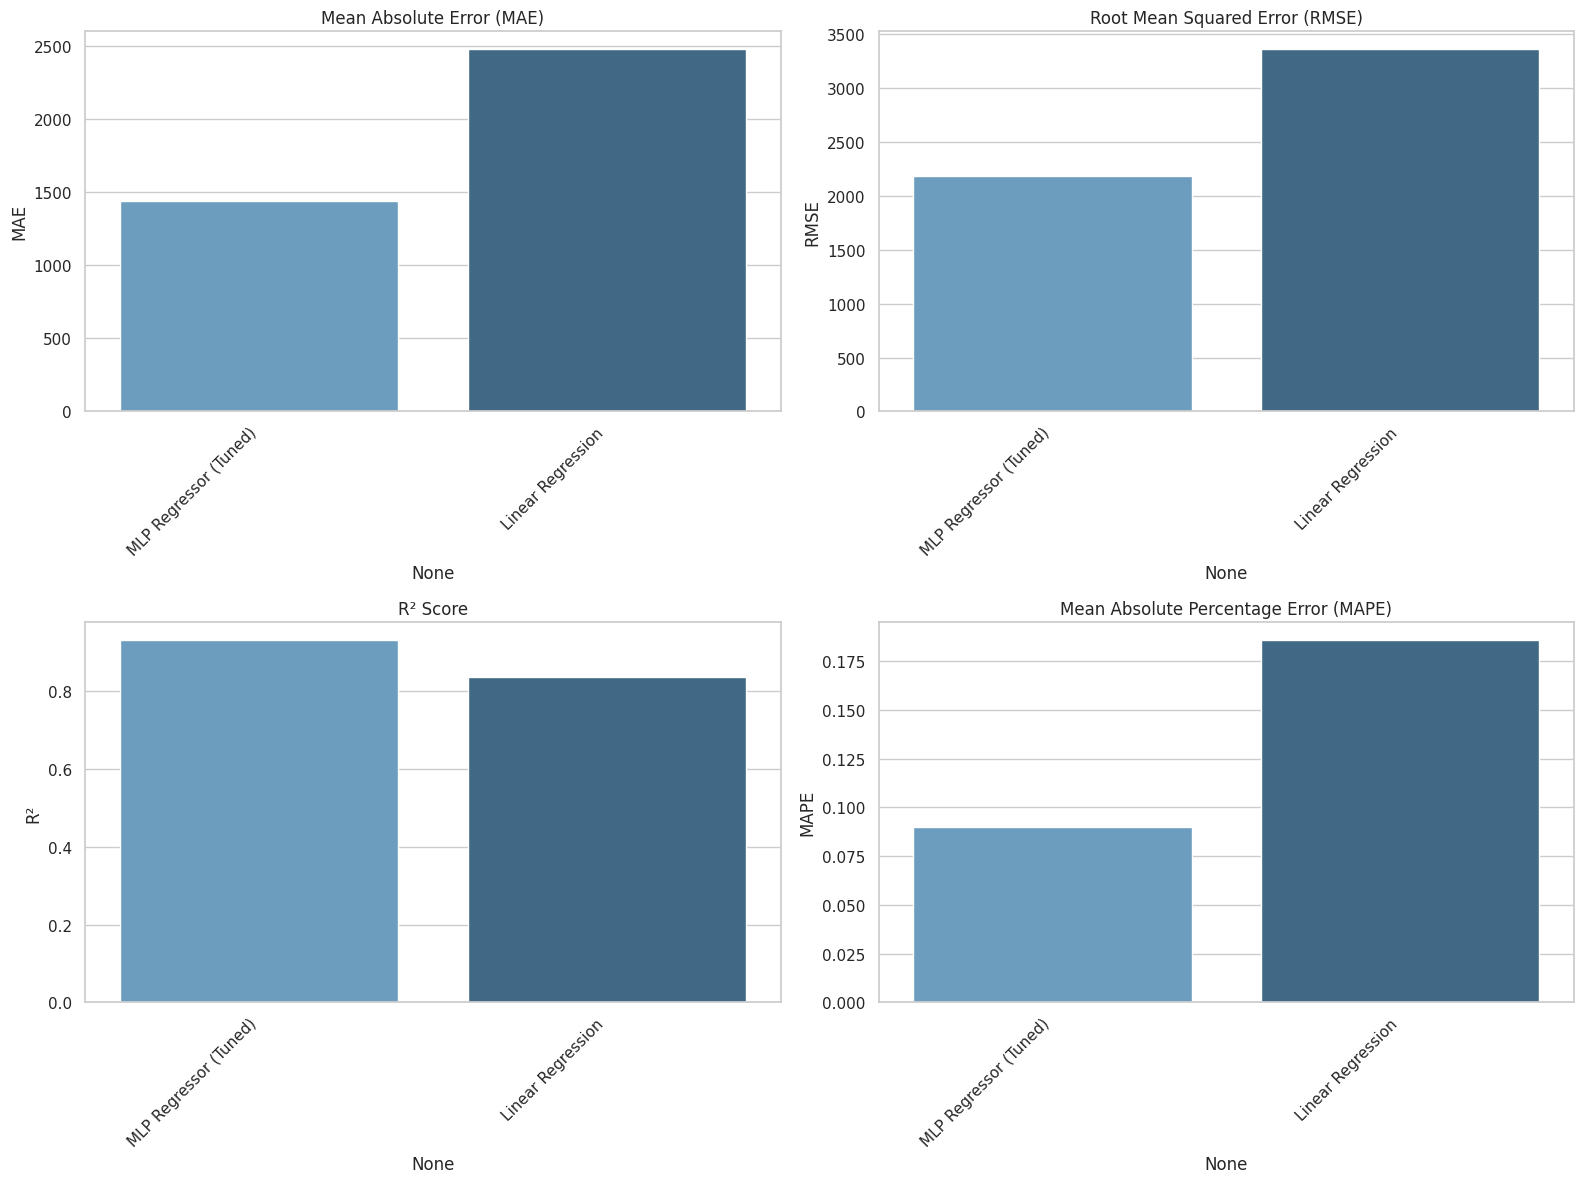


Best MLP Parameters: {'regressor__max_iter': 1000, 'regressor__learning_rate_init': 0.01, 'regressor__learning_rate': 'adaptive', 'regressor__hidden_layer_sizes': (100, 50), 'regressor__early_stopping': True, 'regressor__alpha': 0.001, 'regressor__activation': 'tanh'}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# 1. Load dữ liệu
file_path = "/content/drive/MyDrive/CarsData.csv"
df = pd.read_csv(file_path)

# 2. Loại bỏ cột không cần thiết & loại outliers
if 'model' in df.columns:
    df = df.drop(columns=['model'])

price_threshold = df['price'].quantile(0.99)
mileage_threshold = df['mileage'].quantile(0.99)

df_cleaned = df[
    (df['price'] <= price_threshold) &
    (df['mileage'] <= mileage_threshold) &
    (df['mpg'] >= 10) & (df['mpg'] <= 100) &
    (df['engineSize'] > 0) & (df['engineSize'] <= 5) &
    (df['tax'] <= 500)
]

# 3. Xác định features và target
categorical_features = ['transmission', 'fuelType', 'Manufacturer']
numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
target_col = 'price'

X = df_cleaned.drop(columns=[target_col])
y = df_cleaned[target_col]

# 4. Pipeline tiền xử lý
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
])

# 5. Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Các mô hình
models = {
    "Linear Regression": LinearRegression()
}

# 7. Hàm đánh giá
def evaluate_model(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred)
    }

# 8. Huấn luyện và đánh giá Linear Regression
results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results[name] = evaluate_model(y_test, y_pred)

# 9. GridSearchCV cho MLPRegressor
mlp_param_grid = {
    "regressor__hidden_layer_sizes": [(100,), (100, 50), (50, 25)],
    "regressor__activation": ['relu', 'tanh'],
    "regressor__alpha": [0.0001, 0.001, 0.01],
    "regressor__learning_rate": ['constant', 'adaptive'],
    "regressor__learning_rate_init": [0.0001, 0.001, 0.01],
    "regressor__max_iter": [1000],
    "regressor__early_stopping": [True]
}

mlp_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", MLPRegressor(random_state=42))
])

grid_mlp = RandomizedSearchCV(
    mlp_pipe,
    mlp_param_grid,
    n_iter=20,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

grid_mlp.fit(X_train, y_train)
y_pred_mlp = grid_mlp.predict(X_test)
results["MLP Regressor (Tuned)"] = evaluate_model(y_test, y_pred_mlp)

# 10. Hiển thị kết quả
results_df = pd.DataFrame(results).T.sort_values("RMSE")
print(results_df)

# 11. Trực quan hóa
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['MAE', 'RMSE', 'R²', 'MAPE']
titles = ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'R² Score', 'Mean Absolute Percentage Error (MAPE)']

for ax, metric, title in zip(axs.flatten(), metrics, titles):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=ax, palette='Blues_d')
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

# 12. In ra best params của MLP
print("\nBest MLP Parameters:", grid_mlp.best_params_)


In [ ]:
Huấn luyện mô hình resnet + xgboost + lightgbm

In [ ]:
# --- 0. Thư viện ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from math import sqrt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Load dữ liệu ---
df = pd.read_csv("CarsData.csv")
if 'model' in df.columns:
    df.drop(columns=['model'], inplace=True)

df = df[
    (df['price'] <= df['price'].quantile(0.99)) &
    (df['mileage'] <= df['mileage'].quantile(0.99)) &
    (df['mpg'] >= 10) & (df['mpg'] <= 100) &
    (df['engineSize'] > 0) & (df['engineSize'] <= 5) &
    (df['tax'] <= 500)
]

categorical = ['transmission', 'fuelType', 'Manufacturer']
numerical = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
target_col = 'price'

X = df.drop(columns=[target_col])
y = df[target_col].values  # ← chuyển thành numpy array

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical)
])

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# --- 2. Định nghĩa ResNet ---
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
    def forward(self, x):
        return x + self.block(x)

class ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_blocks=4):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.Sequential(*[ResidualBlock(hidden_dim) for _ in range(num_blocks)])
        self.dropout = nn.Dropout(0.1)
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = self.blocks(x)
        x = self.dropout(x)
        return self.output_layer(x)

# --- 3. Huấn luyện ResNet ---
def train_resnet(X_train, y_train, X_val, y_val, epochs=100, lr=1e-3):
    model = ResNet(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss.item():.4f}")

    return model

# --- 4. Tạo đặc trưng từ ResNet ---
resnet_model = train_resnet(X_train, y_train, X_test, y_test)
X_train_resnet = resnet_model(torch.tensor(X_train, dtype=torch.float32)).detach().numpy()
X_test_resnet  = resnet_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

X_train_ext = np.hstack([X_train, X_train_resnet])
X_test_ext = np.hstack([X_test, X_test_resnet])

# --- 5. Lặp XGBoost ↔ LightGBM ---
prev_rmse = float('inf')
tolerance = 1e-2
max_iter = 5
print("=== Bắt đầu huấn luyện DXL Framework ===")

for i in range(1, max_iter + 1):
    print(f"\n🔁 Vòng lặp {i}")

    if i % 2 == 1:
        model = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=8,
                             subsample=0.8, colsample_bytree=0.9, random_state=42,
                             objective='reg:squarederror')
    else:
        model = LGBMRegressor(n_estimators=150, learning_rate=0.1, max_depth=-1,
                              num_leaves=32, subsample=0.8, colsample_bytree=0.8,
                              bagging_freq=2, random_state=42)

    model.fit(X_train_ext, y_train)
    y_pred = model.predict(X_test_ext)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"➡️  RMSE vòng {i}: {rmse:,.2f}")

    if prev_rmse - rmse < tolerance:
        print(f"✅ Dừng lặp do không cải thiện đáng kể (< {tolerance})")
        break

    prev_rmse = rmse

    # Nối đặc trưng dự đoán vào cho vòng sau
    X_train_ext = np.hstack([X_train_ext, model.predict(X_train_ext).reshape(-1, 1)])
    X_test_ext = np.hstack([X_test_ext, model.predict(X_test_ext).reshape(-1, 1)])

# --- 6. Đánh giá cuối cùng ---
r2 = r2_score(y_test, y_pred)
print(f"\n📌 Kết quả cuối cùng: RMSE = {rmse:,.2f}, R² = {r2:.3f}")


Epoch 1/100, Val Loss: 6879676.5000
Epoch 11/100, Val Loss: 6719393.0000
Epoch 21/100, Val Loss: 4759526.5000
Epoch 31/100, Val Loss: 4304136.0000
Epoch 41/100, Val Loss: 4868530.5000
Epoch 51/100, Val Loss: 4539582.5000
Epoch 61/100, Val Loss: 4211781.5000
Epoch 71/100, Val Loss: 4302252.5000
Epoch 81/100, Val Loss: 3924274.2500
Epoch 91/100, Val Loss: 4057877.5000
Epoch 100/100, Val Loss: 4129347.7500
=== Bắt đầu huấn luyện DXL Framework ===

🔁 Vòng lặp 1
➡️  RMSE vòng 1: 1,827.93

🔁 Vòng lặp 2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 75858, number of used featur

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
➡️  RMSE vòng 2: 1,847.75
✅ Dừng lặp do không cải thiện đáng kể (< 0.01)

📌 Kết quả cuối cùng: RMSE = 1,847.75, R² = 0.951


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
đánh giá chỉ số của mô hình

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):  # Custom MAPE
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\n📊 Đánh giá mô hình:")
print(f"MAE  = {mae:,.2f}")
print(f"RMSE = {rmse:,.2f}")
print(f"R²   = {r2:.3f}")
print(f"MAPE = {mape:.2f}%")



📊 Đánh giá mô hình:
MAE  = 1,215.91
RMSE = 1,847.75
R²   = 0.951
MAPE = 7.73%


In [ ]:
trực quan hóa mô hình restnest + xgboost + lightgbm

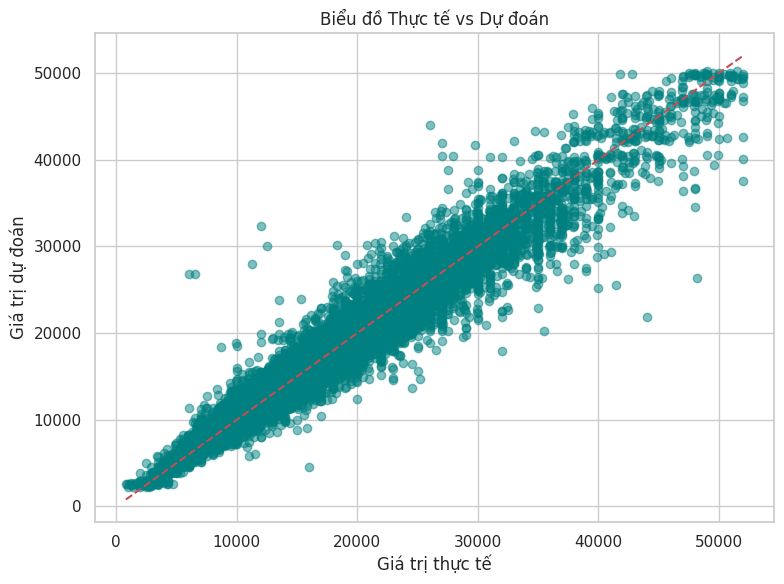

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Giá trị thực tế")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Thực tế vs Dự đoán")
plt.grid(True)
plt.tight_layout()
plt.show()
